In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import seaborn as sns

from math import *

In [2]:
sensor_id = -1408237098

directory_path = '../pos_tables/{}'.format(sensor_id)
path = '../results/{}'.format(sensor_id) ## for saving
os.makedirs(path, exist_ok=True)

# List all files in the directory
files = os.listdir(directory_path)

df_list = []

i = 0
# Iterate through the files and read each one
for file_name in files:
    if(file_name != '.DS_Store'):
        file_path = os.path.join(directory_path, file_name)
        df_list.append(pd.read_csv(file_path))

## Get receiver lat, lon

In [3]:
df_sensors = pd.read_json('file:///Users/mfrahman/Python/adsb_reception_prob_model/sensors/sensor_list_with_country.json')

df_sensors['position'] = df_sensors['position'].apply(dict)

df_sensors['lat'] = df_sensors['position'].apply(lambda x: x['latitude'])
df_sensors['lon'] = df_sensors['position'].apply(lambda x: x['longitude'])
df_sensors['alt'] = df_sensors['position'].apply(lambda x: x['altitude'])

lat_receiver = df_sensors[df_sensors['serial'] == sensor_id]['lat']
lon_receiver = df_sensors[df_sensors['serial'] == sensor_id]['lon']
alt_receiver = df_sensors[df_sensors['serial'] == sensor_id]['alt']

## Define functions

In [4]:
def haversine(lat1, lon1, lat_receiver, lon_receiver):
    R = 6371.0  # radius of the Earth in km

    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat_receiver_rad = radians(lat_receiver)
    lon_receiver_rad = radians(lon_receiver)

    dlon = lon_receiver_rad - lon1_rad
    dlat = lat_receiver_rad - lat1_rad

    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat_receiver_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance/1.852  # in NM

In [5]:
def get_cum(freq):
    cum_list = []
    cum = 0
    
    for f in freq:
        cum += f
        cum_list.append(cum)
        
    return np.array(cum_list)

In [6]:
df_filtered = []

for df_ in df_list:
    df_filtered_ = df_[['mintime', 'maxtime', 'rawmsg', 'icao24', 'lat', 'lon', 'alt', 'sensors', 'nb_of_traffic']]
    df_filtered.append(df_filtered_)
    
    # df = pd.concat([df1, df2, df3, df4, df5, df6, df7])
df= pd.concat(df_filtered)

df.drop_duplicates(subset=['rawmsg'], inplace = True)
df.dropna(subset=["lat"], inplace=True)
df.dropna(subset=["lon"], inplace=True)
df.dropna(subset=["alt"], inplace=True)
# df_tls['sensors'] = df_tls['sensors'].apply(ast.literal_eval)

# df_tls[['mintime_sensor']] = df_tls['sensors'].apply(lambda x: pd.Series(get_mintime_sensor(x)))

In [7]:
df_grouped = df.groupby('icao24', group_keys=True).apply(lambda x: x)

df_grouped['updateinterval'] = df_grouped['mintime'].diff()

df_grouped = df_grouped[(df_grouped['updateinterval'] > 0.0) & (df_grouped['updateinterval'] < 10)]
df = df_grouped.reset_index(drop=True)

In [8]:
df['range_NM'] = df.apply(lambda row: haversine(row['lat'], row['lon'], lat_receiver, lon_receiver), axis=1)

## Filter Outlier

In [9]:
from scipy import stats

# Calculate the z-score for each range
z = np.abs(stats.zscore(df['range_NM']))

# Identify outliers as students with a z-score greater than 5
threshold = 4
outliers = df[z > threshold]

df = df.drop(outliers.index)

# Get Parameters

In [10]:
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

# Assuming 'lat' and 'lon' are columns in your DataFrame df
points = df[['lon', 'lat']].values

# Compute convex hull
hull = ConvexHull(points)

# Convert the convex hull points to a list of tuples
hull_points = [tuple(points[idx]) for idx in hull.vertices]

# Create a shapely Polygon object from the hull points
polygon = Polygon(hull_points)

In [11]:
from shapely.geometry import Point

df_airport = pd.read_csv('../airports/airports.csv')

#take only medium to large airports
airport_crit = (df_airport['type'] == 'medium_airport') | (df_airport['type'] == 'large_airport')
df_airport = df_airport[airport_crit]

df_airport['inside_poly'] = False

# Iterate over each airport point and check if it's inside the polygon
for idx, row in df_airport.iterrows():
    point = Point(row['longitude_deg'], row['latitude_deg'])
    if polygon.contains(point):
        df_airport.at[idx, 'inside_poly'] = True
        
df_airport = df_airport[df_airport['inside_poly']]

/Users/mfrahman/anaconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/mfrahman/anaconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/mfrahman/anaconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/mfrahman/anaconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


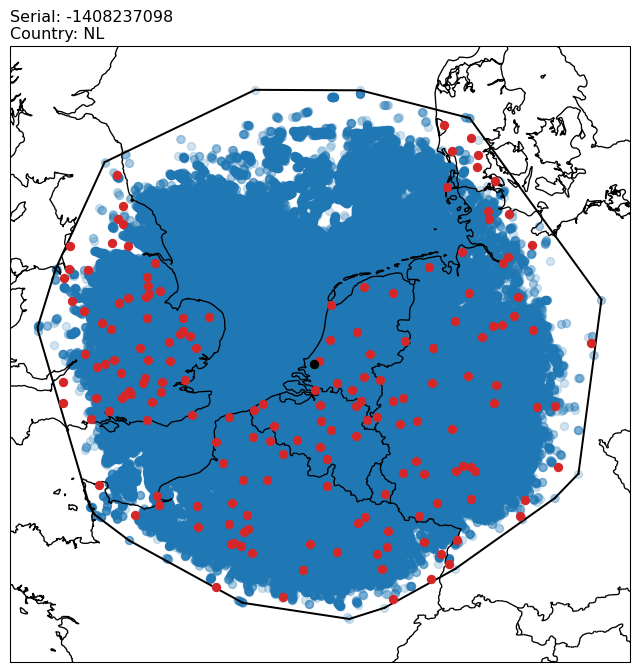

In [12]:
import numpy as np
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define the projection used to display the circle:
proj = ccrs.Orthographic(central_longitude=float(lon_receiver), central_latitude=float(lat_receiver))

# define image properties
width = 800
height = 800
dpi = 96
resolution = '50m'

# create figure
fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Plot the convex hull
ax.scatter(points[:,0], points[:,1], color='tab:blue', alpha = 0.2, transform = ccrs.PlateCarree())

ax.scatter(df_airport['longitude_deg'], df_airport['latitude_deg'], color = 'tab:red', zorder = 20, transform = ccrs.PlateCarree())
ax.scatter(lon_receiver, lat_receiver, color = 'black', zorder = 20, transform = ccrs.PlateCarree())

for simplex in hull.simplices:
    ax.plot(points[simplex, 0], points[simplex, 1], 'k-', transform = ccrs.PlateCarree())


ax.add_feature(cartopy.feature.COASTLINE, color = 'black', linestyle='-', alpha=1.0)
ax.add_feature(cartopy.feature.BORDERS, color = 'black', linestyle='-', alpha=1.0)

ax.scatter(lon_receiver, lat_receiver, color = 'green')

country = df_sensors.loc[df_sensors['serial'] == sensor_id]['country']
country = country.to_string()[-2:]
plt.title('Serial: {}\nCountry: {}'.format(sensor_id, country), loc = 'left')

plt.axis('equal')

plt.savefig('{}/coverage.png'.format(path), dpi = dpi)
plt.show()

## Calculate the area coverage

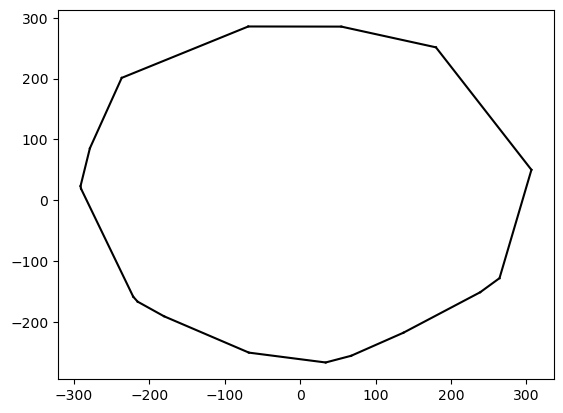

In [131]:
x_coordinates = []
y_coordinates = []

for point in hull_points:
    lon_, lat_ = point
    x = haversine(lat_, lon_receiver, lat_receiver, lon_receiver)
    y = haversine(lat_receiver, lon_, lat_receiver, lon_receiver)
    
    if(lat_ < lat_receiver.values):
        x = -x
    if(lon_ < lon_receiver.values):
        y = -y
    
    x_coordinates.append(x)
    y_coordinates.append(y)
    
x_coordinates = np.array(x_coordinates)
y_coordinates = np.array(y_coordinates)

points_km = np.column_stack((y_coordinates, x_coordinates))

hull_km = ConvexHull(points_km)

for simplex in hull_km.simplices:
    plt.plot(points_km[simplex, 0], points_km[simplex, 1], 'k-')  # Connect vertices of convex hull
    
hull_km_area = hull_km.volume

## Calculate the volume coverage

In [142]:
points_3d = df[['lon', 'lat', 'alt']].values
hull_3d = ConvexHull(points_3d)

# Convert the convex hull points to a list of tuples
hull_points_3d = [tuple(points_3d[idx]) for idx in hull_3d.vertices]

x_coordinates = []
y_coordinates = []
z_coordinates = []

for point in hull_points_3d:
    lon_, lat_, alt = point
    x = haversine(lat_, lon_receiver, lat_receiver, lon_receiver)
    y = haversine(lat_receiver, lon_, lat_receiver, lon_receiver)
    
    if(lat_ < lat_receiver.values):
        x = -x
    if(lon_ < lon_receiver.values):
        y = -y
    
    x_coordinates.append(x)
    y_coordinates.append(y)
    z_coordinates.append(alt/1000)

x_coordinates = np.array(x_coordinates)
y_coordinates = np.array(y_coordinates)
z_coordinates = np.array(z_coordinates)

points_km_3d = np.column_stack((y_coordinates, x_coordinates, z_coordinates))

hull_3d_km = ConvexHull(points_km_3d)

# for simplex in hull_km.simplices:
#     plt.plot(points_km[simplex, 0], points_km[simplex, 1], 'k-')  # Connect vertices of convex hull
    
hull_km_volume = hull_3d_km.volume

## Get airport in coverage

In [143]:
# Calculate max distance
max_distance = df['range_NM'].max()

# Calculate number of airports
nb_airport_med_lar = len(df_airport)

# Calculate number of airports with scheduled service
nb_airport_med_lar_scheduled = len(df_airport[df_airport['scheduled_service'] == 'yes'])

# Create a dictionary with the data
data = {
    'max_distance': [max_distance],
    'horizontal_coverage': [hull_km_area],
    'volume_coverage': [hull_km_volume],
    'max_distance': [max_distance],
    'nb_airport_med_lar': [nb_airport_med_lar],
    'nb_airport_med_lar_scheduled': [nb_airport_med_lar_scheduled]
}

# Create DataFrame
params_df = pd.DataFrame(data)

params_df

,max_distance,horizontal_coverage,volume_coverage,nb_airport_med_lar,nb_airport_med_lar_scheduled
0,307.886584,248045.514972,2.699000e+06,173,63


## Get Number of Data

In [38]:
df_all_bin = []
df_all_bin_size = []

df_avg_range = []

traf_bin_width = 10
range_bin_width = 10

max_traf = max(df['nb_of_traffic'])
max_range = 250

nb_of_cat_range = int(np.floor(max_range/range_bin_width))
nb_of_cat_traf = int(np.floor(max_traf/traf_bin_width))

for i in range(nb_of_cat_range):
    df_range_all = []
    df_range_all_size = []
    
    df_avg_range_ = []
    
    for j in range(nb_of_cat_traf):
        traf_crit = ((df['nb_of_traffic'] > j*traf_bin_width) & (df['nb_of_traffic'] <= (j+1)*traf_bin_width))
        range_crit = ((df['range_NM'] > i*range_bin_width) & (df['range_NM'] <= (i+1)*range_bin_width))
        
        all_crit = traf_crit & range_crit
        
        df_range_all.append(df[all_crit])
        df_range_all_size.append(len(df[all_crit]))
        
        df_avg_range_.append(df.loc[traf_crit]['range_NM'].mean())
        
    df_all_bin.append(df_range_all)
    df_all_bin_size.append(df_range_all_size)
    
    df_avg_range.append(df_avg_range_)

In [48]:
range_arr = np.arange(range_bin_width, max_range, range_bin_width)
traf_arr = np.arange(traf_bin_width, max_traf, traf_bin_width)
data_size = np.array(df_all_bin_size).T
df_avg_range = np.array(df_avg_range).T

range_arr_col = np.append(range_arr, [max_range])

df_nb_of_data = pd.DataFrame(data_size[:], columns = range_arr_col)
df_avg_range = pd.DataFrame(df_avg_range[:], columns = range_arr_col)

df_nb_of_data

,10,20,30,40,50,60,70,80,90,100,...,160,170,180,190,200,210,220,230,240,250
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,291,182,185,519,619,728,616,263,318,715,...,524,764,528,570,227,272,196,140,188,8
2,982,1868,3580,5570,8158,10255,10104,8867,9187,8467,...,8870,7909,6210,5350,3834,3242,2819,1533,970,348
3,1706,4826,7304,10486,16052,23680,23659,21810,20364,16654,...,14159,13471,10910,8828,6606,5183,4898,3033,1399,373
4,4489,8437,16310,23576,30508,40802,36778,35261,35218,29192,...,27121,20297,17680,13494,12569,8332,6756,4814,2318,569
5,2839,8357,15305,18707,28190,36500,35655,32750,31534,25757,...,22119,17496,14940,12561,10341,9193,7386,4659,2466,881
6,1642,3786,5871,6106,12288,13783,13851,12036,9833,9211,...,7929,5944,5327,4340,3503,3352,2748,1723,952,557
7,537,1302,2914,3748,4617,5698,5927,5590,3419,3195,...,3010,2233,1988,1992,1650,1389,1234,894,420,193
8,1124,3234,5588,5144,9022,10749,10716,9419,8607,6796,...,5493,3880,3648,3270,2870,2157,1787,1256,925,246
9,2318,4621,5673,7900,9779,9614,9933,8958,7872,7629,...,5515,4202,4313,3109,2988,2547,1892,1475,879,390


## Get Prob

In [16]:
start = 0.0
end = 5.0
nb_of_bar = 20

range_idx = 0

first_bump = []
second_bump = []

for df_traf in df_all_bin:
    traf_idx = 0
    
    first_bump_ = []
    second_bump_ = []
    
    for df_loc in df_traf:
        input_list = np.array(df_loc['updateinterval'].to_list())
        
        bins = np.linspace(start, end, int(((end-start)*nb_of_bar+1)))
        weightsa = np.ones_like(input_list)/float(len(input_list))
        freq_, edge_ = np.histogram(input_list, bins, weights = weightsa)
        
        freq_ = np.array(freq_)
        edge_ = np.array(edge_)
        cum_ = get_cum(freq_)
        
        first_bump_.append(cum_[edge_[:-1] == 0.75][0]*100)
        second_bump_.append(cum_[edge_[:-1] == 1.25][0]*100)
        
        traf_idx +=1
        
    first_bump.append(first_bump_)
    second_bump.append(second_bump_)
        
    range_idx +=1
    
first_bump = np.array(first_bump).T
second_bump = np.array(second_bump).T

## Save to CSV

In [144]:
df_nb_of_data = pd.DataFrame(data_size[:], columns = range_arr_col)
df_prob_first_bump = pd.DataFrame(first_bump[:], columns = range_arr_col)
df_prob_second_bump = pd.DataFrame(second_bump[:], columns = range_arr_col)

df_prob_first_bump.to_csv('{}/probability_first_bump.csv'.format(path))
df_prob_second_bump.to_csv('{}/probability_second_bump.csv'.format(path))
df_nb_of_data.to_csv('{}/nb_data.csv'.format(path))
df_avg_range.to_csv('{}/avg_range.csv'.format(path))

params_df.to_csv('{}/params.csv'.format(path))